In [1]:
# !pip3 install pykitti
# !wget https://raw.githubusercontent.com/navoshta/KITTI-Dataset/master/source/parseTrackletXML.py

# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0048/2011_09_26_drive_0048_sync.zip
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0048/2011_09_26_drive_0048_tracklets.zip

# !unzip 2011_09_26_drive_0048_sync.zip
# !unzip 2011_09_26_calib.zip
# !unzip 2011_09_26_drive_0048_tracklets.zip

In [2]:
import pykitti
import parseTrackletXML as xmlParser
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
dataset = pykitti.raw('.', '2011_09_26', '0048')

In [4]:
dataset.calib.T_velo_imu, dataset.calib.b_gray, dataset.calib.b_rgb

(array([[ 9.999976e-01,  7.553071e-04, -2.035826e-03, -8.086759e-01],
        [-7.854027e-04,  9.998898e-01, -1.482298e-02,  3.195559e-01],
        [ 2.024406e-03,  1.482454e-02,  9.998881e-01, -7.997231e-01],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]]),
 0.537150600500771,
 0.5327254400790535)

In [5]:
dataset_gray = list(dataset.gray)
dataset_rgb = list(dataset.rgb)
dataset_velo = list(dataset.velo)

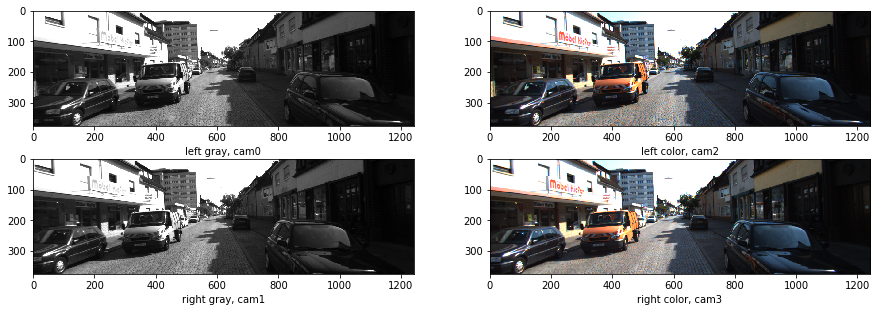

In [6]:
plt.figure(figsize = (15, 5))
plt.subplot(2, 2, 1)
plt.imshow(dataset_gray[0][0], cmap = 'gray')
plt.xlabel('left gray, cam0')
plt.subplot(2, 2, 2)
plt.imshow(dataset_rgb[0][0])
plt.xlabel('left color, cam2')
plt.subplot(2, 2, 3)
plt.imshow(dataset_gray[0][1], cmap = 'gray')
plt.xlabel('right gray, cam1')
plt.subplot(2, 2, 4)
plt.imshow(dataset_rgb[0][1])
plt.xlabel('right color, cam3')
plt.show()

In [7]:
percent_use = 0.2

points_step = int(1. / percent_use)
point_size = 0.01 * (1. / percent_use)
velo_range = range(0, dataset_velo[0].shape[0], points_step)
velo_frame = dataset_velo[0][velo_range, :]     

In [8]:
dataset_velo[0].shape, velo_frame.shape

((119977, 4), (23996, 4))

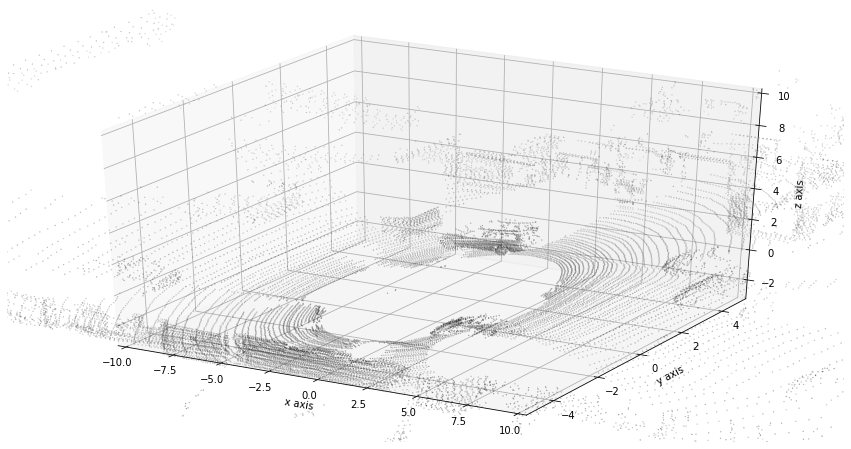

In [9]:
axes_limits = [
    [-10, 10], # X axis range
    [-5, 5], # Y axis range
    [-3, 10]   # Z axis range
]

f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111, projection='3d')

ax.scatter(velo_frame[:,0], velo_frame[:,1], velo_frame[:,2], s=point_size, c=velo_frame[:, 3], cmap='gray')
ax.set_xlim3d(*axes_limits[0])
ax.set_ylim3d(*axes_limits[1])
ax.set_zlim3d(*axes_limits[2])

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
plt.show()

In [10]:
import numpy as np

def load_tracklets_for_frames(n_frames, xml_path):
    tracklets = xmlParser.parseXML(xml_path)

    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []

    for i, tracklet in enumerate(tracklets):
        h, w, l = tracklet.size
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
            if truncation not in (xmlParser.TRUNC_IN_IMAGE, xmlParser.TRUNC_TRUNCATED):
                continue
            yaw = rotation[2]
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber] + [
                tracklet.objectType]

    return (frame_tracklets, frame_tracklets_types)

In [11]:
xml_path = '2011_09_26/2011_09_26_drive_0048_sync/tracklet_labels.xml'
tracklet_rects, tracklet_types = load_tracklets_for_frames(len(list(dataset.velo)), xml_path)

Parsing tracklet file 2011_09_26/2011_09_26_drive_0048_sync/tracklet_labels.xml
File contains 8 tracklets
Loaded 8 tracklets.


In [12]:
list(zip(tracklet_rects[0], tracklet_types[0]))

[(array([[14.88969847, 14.84102989,  9.66230673,  9.71097532, 14.88969847,
          14.84102989,  9.66230673,  9.71097532],
         [ 1.93657796,  3.95639749,  3.8316135 ,  1.81179397,  1.93657796,
           3.95639749,  3.8316135 ,  1.81179397],
         [-1.74386144, -1.74386144, -1.74386144, -1.74386144,  0.30224036,
           0.30224036,  0.30224036,  0.30224036]]), 'Van'),
 (array([[10.43284391, 10.38973275,  6.50415467,  6.54726583, 10.43284391,
          10.38973275,  6.50415467,  6.54726583],
         [ 4.52531805,  6.11148539,  6.0058775 ,  4.41971016,  4.52531805,
           6.11148539,  6.0058775 ,  4.41971016],
         [-1.85662723, -1.85662723, -1.85662723, -1.85662723, -0.45838853,
          -0.45838853, -0.45838853, -0.45838853]]), 'Car'),
 (array([[ 6.54078718,  6.61298665,  3.10885429,  3.03665482,  6.54078718,
           6.61298665,  3.10885429,  3.03665482],
         [-3.36875656, -1.7853827 , -1.62559953, -3.20897339, -3.36875656,
          -1.7853827 , -1.6255

In [13]:
colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}

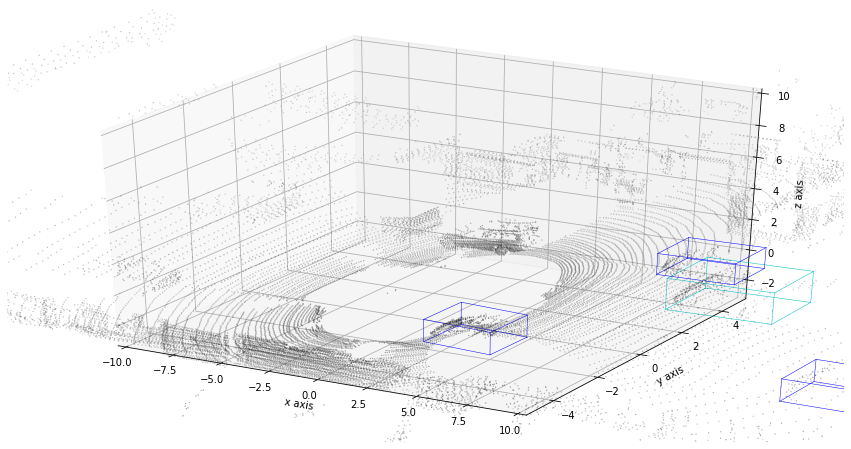

In [14]:
axes_limits = [
    [-10, 10], # X axis range
    [-5, 5], # Y axis range
    [-3, 10]   # Z axis range
]

f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111, projection='3d')

ax.scatter(velo_frame[:,0], velo_frame[:,1], velo_frame[:,2], s=point_size, c=velo_frame[:, 3], cmap='gray')
ax.set_xlim3d(*axes_limits[0])
ax.set_ylim3d(*axes_limits[1])
ax.set_zlim3d(*axes_limits[2])

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

for t_rects, t_type in zip(tracklet_rects[0], tracklet_types[0]):
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        ax.plot(*t_rects[:, connection], c=colors[t_type], lw=0.5)
        
plt.show()

In [15]:
T_cam_velo, Rrect, Prect = dataset.calib.T_cam3_velo, dataset.calib.R_rect_30, dataset.calib.P_rect_30

In [16]:
pts3d = dataset_velo[0]
pts3d = pts3d[pts3d[:, 3] > 0 ,:]
pts3d[:,3] = 1
pts3d = pts3d.transpose()

In [17]:
pts3d[:,0]

array([52.301,  7.3  ,  1.995,  1.   ], dtype=float32)

In [18]:
pts3d_cam = Rrect.dot(T_cam_velo.dot(pts3d))
pts3d_cam.shape

idx = (pts3d_cam[2,:]>=0)
pts2d_cam = Prect.dot(pts3d_cam[:,idx])

pts2d = pts2d_cam/pts2d_cam[2,:]
pts3d_idx = pts3d[:, idx]
pts3d_idx.shape, pts2d.shape

((4, 50246), (3, 50246))

In [19]:
pts3d_idx = pts3d_idx[:,((pts2d[0] < 1200) & (pts2d[1] < 375) & (pts2d[0] > 0) & (pts2d[1] > 0))]
pts3d_idx.shape

(4, 12624)

In [20]:
pts2d = pts2d[:,((pts2d[0] < 1200) & (pts2d[1] < 375) & (pts2d[0] > 0) & (pts2d[1] > 0))]

In [21]:
x = pts2d[0]
y = pts2d[1]
z = pts2d[2]
x.shape, y.shape

((12624,), (12624,))

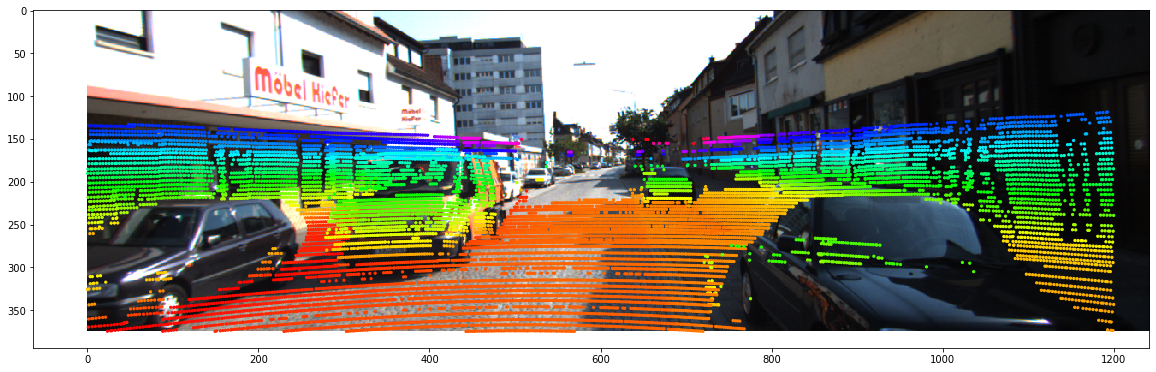

In [22]:
plt.figure(figsize = (20, 20))
plt.imshow(dataset_rgb[0][1])
plt.scatter(x, y, c = pts3d_idx[2], s = 5, cmap = 'hsv')

In [23]:
concated = np.concatenate([tracklet_rects[0][0], np.ones((1,8))], axis = 0)
concated.shape

(4, 8)

In [24]:
pts3d_cam_concated = Rrect.dot(T_cam_velo.dot(concated))

idx = (pts3d_cam_concated[2,:]>=0)
pts2d_cam_concated = Prect.dot(pts3d_cam_concated[:,idx])

pts2d_concated = pts2d_cam_concated/pts2d_cam_concated[2,:]
x_concated = pts2d_concated[0]
y_concated = pts2d_concated[1]

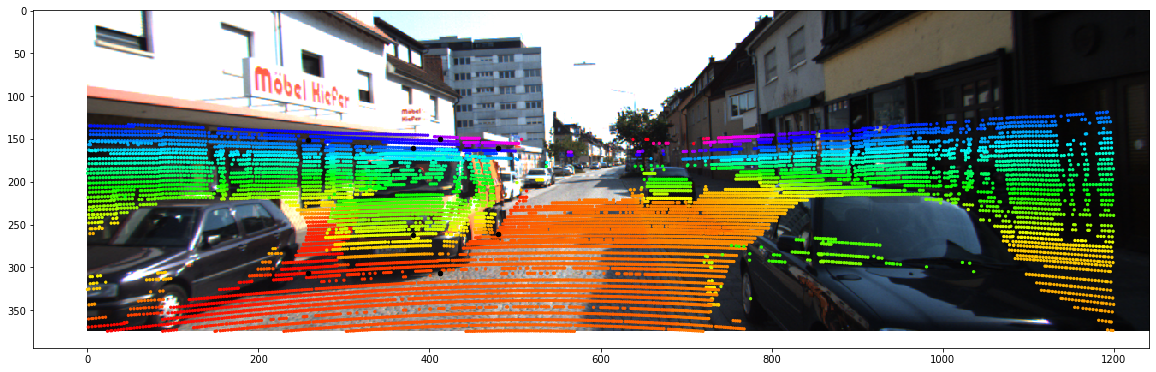

In [25]:
plt.figure(figsize = (20, 20))
plt.imshow(dataset_rgb[0][1])
plt.scatter(x, y, c = pts3d_idx[2], s = 5, cmap = 'hsv')
plt.scatter(x_concated, y_concated, s = 20, c = 'black')

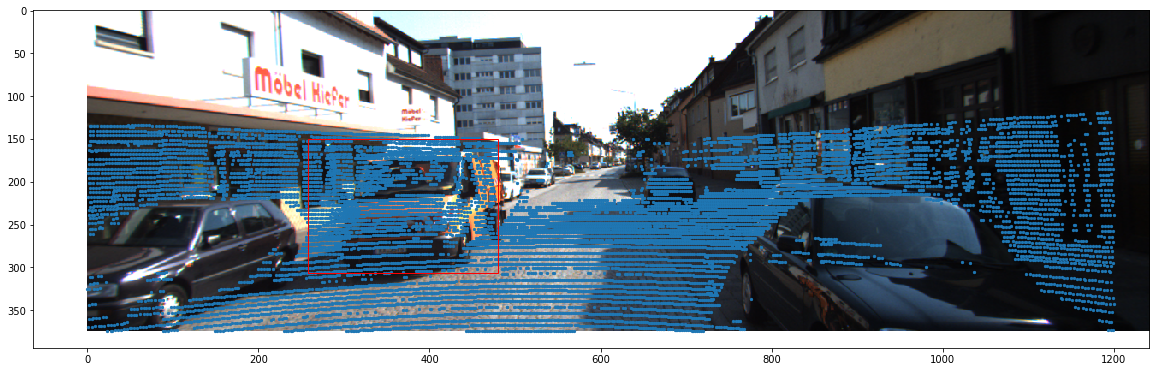

In [26]:
from matplotlib.patches import Rectangle

plt.figure(figsize = (20, 20))
plt.imshow(dataset_rgb[0][1])
plt.scatter(x, y, s = 5)

plt.gca().add_patch(Rectangle((x_concated.min(),y_concated.min()),
                              x_concated.max() - x_concated.min(), 
                              y_concated.max() - y_concated.min(),
                              linewidth=1,edgecolor='r',facecolor='none'))

plt.show()

In [27]:
%%time

import pcl

p = pcl.PointCloud(pts3d_idx[:-1].T)
tree = p.make_kdtree()
ec = p.make_EuclideanClusterExtraction()
ec.set_ClusterTolerance(1.0)
ec.set_MinClusterSize(10)
ec.set_MaxClusterSize(1000)
ec.set_SearchMethod(tree)
cluster_indices = ec.Extract()

CPU times: user 179 ms, sys: 32.8 ms, total: 212 ms
Wall time: 214 ms


In [28]:
clusters, inners = [], []
for j, indices in enumerate(cluster_indices):
    inner = []
    for i, indice in enumerate(indices):
        c = [p[indice][0],
             p[indice][1],
             p[indice][2]]
        clusters.append(c)
        inner.append(c)
    inners.append(inner)
len(clusters)

461

In [29]:
clusters = np.array(clusters)
clusters.shape

(461, 3)

In [30]:
concated = np.concatenate([clusters.T, np.ones((1,clusters.shape[0]))], axis = 0)

pts3d_cam_concated = Rrect.dot(T_cam_velo.dot(concated))

idx = (pts3d_cam_concated[2,:]>=0)
pts2d_cam_concated = Prect.dot(pts3d_cam_concated[:,idx])

pts2d_concated = pts2d_cam_concated/pts2d_cam_concated[2,:]
x_concated = pts2d_concated[0]
y_concated = pts2d_concated[1]

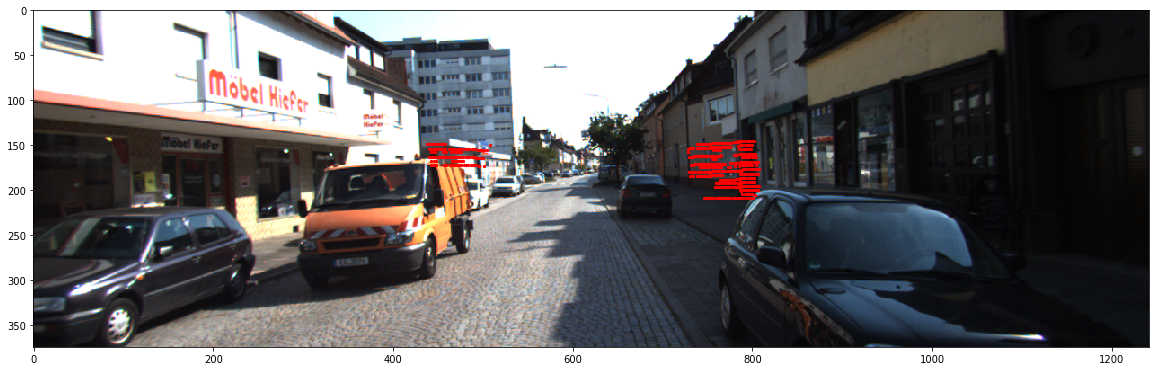

In [31]:
plt.figure(figsize = (20, 20))
plt.imshow(dataset_rgb[0][1])
plt.scatter(x_concated, y_concated, s = 5, c = 'r')